## Imports

In [42]:
import numpy as np

import matplotlib.pyplot as plt

## The Problem

Here we are going to try to predict a single value, a value 10, using 2 parameters $\alpha$ and $\beta$, where our prediction for the true mean is $\alpha + \beta$. As one can already see, we can form the equation $10 = \alpha + \beta$ to express the parameters $\theta = \{\alpha, \beta\}$.

Now lets define an optimization objective such that we want to find parameters $\theta$ that minimize the loss between the predicted values and the true value. The form of this Loss function may take a few forms as MAE or MSE.

$$MAE(\mu, \theta) = | \mu - (\alpha + \beta)|$$
$$MSE(\mu, \theta) = (\mu - (\alpha + \beta))^2$$

However, as one may have already determined, there are an infinite number of solutions to $\theta$ that minimize these losses (in this case the line $\beta = 10-\alpha$).
In this case there will be an infinite amount of disagreement between an infinite number of optimizers. For example on may say the best is (4.5, 5.5), another (5,5) and another may say (3, 7). One can see that any specific optimizer will likely disagree with the solution of another optimizer, or in this case there is an infinite number of local minima.

To remedy this, we use Bayesian Optimization to add an additional constraint to our parameters $\theta$ that transforms out problem from convex (infinite local minima), to strictly convex (1 global minima). 



## Defining true mean for our example

In [43]:
true_mean = 10
mean_sigma = 1

In our optimization problem, we deal with the minimization of loss, but in Bayesian Optimization we deal with the maximization of probability. One can relate one to the other through a Likelihood function, one common one is Gaussian Likelihood 

$$P(x| \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp(-\frac{(x - \mu)^2}{2\sigma^2})$$

One can relate this to a Loss already by noticing the MSE loss in the exponential. A more rigourous proof of the link is through the optimization objectives. One seeks to maximize the probability of the parameters ($\mu, \sigma$) explaining the data x. In this optimization, we can apply a monotone function, such as $\log$, without affecting the optimization objective.

$$ \max(P(x|\mu,\sigma)) = \max(\log(P(x|\mu, \sigma)))$$
$$ \max(\log(P(x|\mu, \sigma))) = max(\log(\frac{1}{\sqrt{2 \pi \sigma^2}}) - \frac{(x - \mu)^2}{2\sigma^2})$$

Now if we assume $\sigma$ is a constant $\frac{1}{\sqrt{2}}$, which allows us to neglect the first term in the maximization,

$$ \max(\log(P(x|\mu, \sigma))) = max(- (x - \mu)^2)$$

Now the maximization of a negative value is minimization of a positive,

$$ \max(\log(P(x|\mu, \sigma))) = min((x - \mu)^2)$$

Which shows maximizing the probability of the parameters $\theta$ is equivalent the minimizing loss

## Log Likelihood Function

In [44]:
def log_likelihood(x, mean, sigma):

    log_prob = np.log(1 / (np.sqrt(2 * np.pi * sigma**2))) - (x - mean)**2 / (2*sigma**2)

    return log_prob

Now that we have defined our likelihood function we can see what it looks like in a 2D space defined by ($\alpha, \beta$). Where the parameters of our likelihood are $P(x| (\alpha + \beta), 1)$.

## Defining Grid to plot Likelihood

In [45]:
grid_size = 1000

grid_bounds = (-2, 12)

alpha = np.linspace(grid_bounds[0], grid_bounds[1], grid_size)
beta = np.linspace(grid_bounds[0], grid_bounds[1], grid_size)


alpha_grid, beta_grid = np.meshgrid(alpha, beta)

true_mean_grid = np.ones((grid_size, grid_size)) * true_mean

data_log_prob = log_likelihood(true_mean_grid, alpha_grid + beta_grid, mean_sigma)

## Plotting Likelihood Optimization without a prior

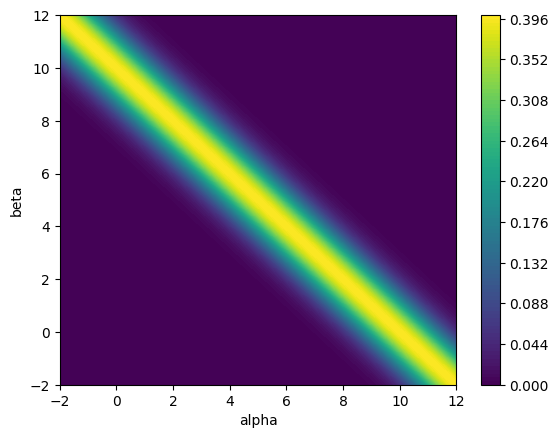

In [46]:
plt.contourf(alpha_grid, beta_grid, np.exp(data_log_prob), 100, cmap='viridis')
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')

plt.show()

Like we had predicted, we see the probability of the parameters $\theta=\{\alpha, \beta\}$ peaks around the line $\beta = 10-\alpha$. Also showing the optimization of the parameters will prove difficult as there are an infinite number of solutions.

Now to remedy this we use Bayesian Optimization to make the optimization strictly convex. To do this we will for another probability distribution know as the posterior. Using Baye's Rule we can express the likelihood of the parameters $\theta$ as,

$$ P(\theta | x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

In our case, we know the likelihood already, and we need to define the 'prior' $P(\theta)$ which encodes our knowledge prior to observing some data. In our case, we will give $\theta$ a Gaussian distribution with parameters $\mu =0$ and $\sigma=4$. This gives a Posterior proportional to $P(\theta |x) = P(x|\theta)P(\alpha|0,1)P(\beta|0,1)$. 

The key word here is proportional to because we have not evalutated the denominator of the posterior. However, luckily for us, the denominator is simply a constant and doesn't affect the optimization.

## Now Lets Add a Prior to Our parameters

In [51]:
alpha_mean = 0
alpha_sigma = 4

beta_mean = 0
beta_sigma = 4

alpha_prior_log_prob = log_likelihood(alpha_grid, alpha_mean, alpha_sigma)
beta_prior_log_prob = log_likelihood(beta_grid, beta_mean, beta_sigma)

## Adding probabilities because they are all in the log space (ie log(a*b) = log(a) + log(b))
posterior_log_prob = alpha_prior_log_prob + beta_prior_log_prob + data_log_prob

## Plotting Posterior Distribution over Parameters with Prior

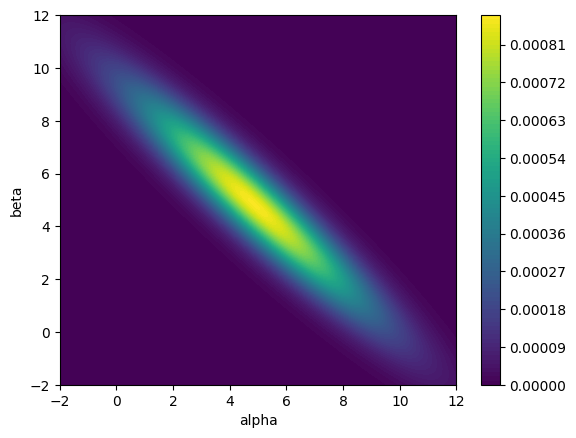

In [52]:
plt.contourf(alpha_grid, beta_grid, np.exp(posterior_log_prob), 100, cmap='viridis')
plt.colorbar()
plt.xlabel('alpha')
plt.ylabel('beta')

plt.show()

## HAZAAH

With the introduction of a prior on our parameters, we have turned a problem with infinite optimal solutions to one with a single optimal solution.